## MSDS 7331 Mini Lab Two: Logistic Regression and Support Vector Machine

### Authors: Jaren Shead, Kristin Henderson, Tom Hines

#### Setup & Data Import

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics as mt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.utils import resample

# Display plots inline
%matplotlib inline

# Load dataset
df = pd.read_csv('data/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Data Cleaning & Preprocessing

In [2]:
# Make a copy of the dataset
df_clean = df.copy()

# Replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)

# Fill missing values
df_clean[['medical_specialty', 'payer_code', 'race']] = df_clean[['medical_specialty', 'payer_code', 'race']].fillna('Unknown')
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown/None')
df_clean[['max_glu_serum', 'A1Cresult']] = df_clean[['max_glu_serum', 'A1Cresult']].fillna('Untested')

# Convert categorical integer variables to category dtype
categorical_int_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_clean[categorical_int_cols] = df_clean[categorical_int_cols].astype('category')

# Drop unnecessary columns
df_clean.drop(columns=['encounter_id', 'examide', 'citoglipton', 'weight', 'patient_nbr'], inplace=True)

# Define ordinal category orders
category_orders = {
    'readmitted': ['<30', '>30', 'NO'],
    'max_glu_serum': ['Untested', 'Norm', '>200', '>300'],
    'A1Cresult': ['Untested', 'Norm', '>7', '>8'],
    'age': ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
            '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
}

# Convert ordinal variables
for col, order in category_orders.items():
    df_clean[col] = pd.Categorical(df_clean[col], categories=order, ordered=True)

# Convert drug variables to ordinal categories
drug_order = ['No', 'Down', 'Steady', 'Up']
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide', 
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'acarbose', 'miglitol', 
                'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'glimepiride-pioglitazone']
for col in drug_cols:
    df_clean[col] = pd.Categorical(df_clean[col], categories=drug_order, ordered=True)

# Preprocess diag_1, diag_2, diag_3 combining all codes with decimals under their integer values
for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].str.split('.').str[0]  # Drop decimals and digits after

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  category
 3   admission_type_id         101766 non-null  category
 4   discharge_disposition_id  101766 non-null  category
 5   admission_source_id       101766 non-null  category
 6   time_in_hospital          101766 non-null  int64   
 7   payer_code                101766 non-null  object  
 8   medical_specialty         101766 non-null  object  
 9   num_lab_procedures        101766 non-null  int64   
 10  num_procedures            101766 non-null  int64   
 11  num_medications           101766 non-null  int64   
 12  number_outpatient         101766 non-null  int64   
 13  number_emergency          101

#### Feature Engineering: Encoding and Scaling

In [3]:
# Extract response variable
y = df_clean['readmitted']
X = df_clean.drop(columns=['readmitted'])

# One-Hot Encoding categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)  # drop_first for multicollinearity issues - log reg

# Standardize numerical features
num_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])


#### Feature Selection

In [4]:
# Extract numerical features before one-hot encoding
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Feature Selection from RF Variable Importance (Done in EDA)
rf_features_js = ['num_lab_procedures', 'diag_1', 'diag_2', 'diag_3', 'num_medications', 'time_in_hospital', 'age', 
                  'number_inpatient', 'medical_specialty', 'discharge_disposition_id', 'payer_code', 'num_procedures', 
                  'number_diagnoses', 'admission_type_id', 'admission_source_id']
rf_features_kh = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_inpatient', 'number_diagnoses', 
                  'num_procedures', 'number_outpatient', 'number_emergency', 'diag_3', 'gender', 'diag_1', 'medical_specialty', 
                  'diag_2', 'payer_code', 'race', 'discharge_disposition_id']

# Get the union of both feature lists (combined RF-selected features)
rf_features_all = list(set(rf_features_js) | set(rf_features_kh))

print(f"Total RF-Selected Features ({len(rf_features_all)}): {rf_features_all}")

# Alternatively, we could take only the common features
# rf_features_common = list(set_js & set_kh)  # OR use set_js.intersection(set_kh)
# print(f"\nFeatures in both RF lists ({len(rf_features_common)}):\n", rf_features_common)

## Create Reduced Datasets with RF-Selected Features

# Identify Categorical Features
rf_features_categorical = list(set(X.select_dtypes(include=['object', 'category']).columns) & set(rf_features_all))
rf_features_numeric = list(set(rf_features_all) - set(rf_features_categorical))  # Keep numeric features

# Identify One-Hot Encoded Columns
one_hot_cols = X_encoded.columns

# Get All One-Hot Encoded Versions of Categorical Features
rf_encoded_features = []
for cat_feat in rf_features_categorical:
    rf_encoded_features.extend([col for col in one_hot_cols if col.startswith(cat_feat + "_")])

# Merge Selected Features: Numeric + One-Hot Encoded Categorical
rf_features_final = rf_features_numeric + rf_encoded_features

print(f"Final RF-Selected Features Count: {len(rf_features_final)}")

# Create the Reduced Dataset
X_rf_selected = X_encoded[rf_features_final]

# Check the new dataset shape
print(f"RF-Selected Dataset Shape: {X_rf_selected.shape}")


Total RF-Selected Features (19): ['diag_2', 'admission_type_id', 'number_diagnoses', 'diag_3', 'gender', 'payer_code', 'medical_specialty', 'number_emergency', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_inpatient', 'diag_1', 'number_outpatient', 'num_medications', 'discharge_disposition_id', 'admission_source_id', 'race']
Final RF-Selected Features Count: 2316
RF-Selected Dataset Shape: (101766, 2316)


#### Dimensionality Reduction with PCA

In [5]:
# Extract response variable
y_pca = df_clean['readmitted']
X_pca = df_clean.drop(columns=['readmitted'])

# One-Hot Encode categorical variables
categorical_cols = X_pca.select_dtypes(include=['object', 'category']).columns
X_pca_encoded = pd.get_dummies(X_pca, columns=categorical_cols, drop_first=False)  # Keep all levels

# Standardize all features (needed for PCA)
scaler = StandardScaler()
X_pca_standardized = scaler.fit_transform(X_pca_encoded)

# Apply PCA (Keep all components initially)
pca = PCA()
X_pca_full = pca.fit_transform(X_pca_standardized)

# Explained variance of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for various variance thresholds
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # 90% variance

# Store PCA-transformed datasets
X_pca_df = pd.DataFrame(X_pca_full, index=X_pca_encoded.index)  # Full PCA dataset
X_pca_90 = pd.DataFrame(X_pca_full[:, :n_components_90], index=X_pca_encoded.index)  # 90% variance

# Check dataset shape
print(f"PCA (90% Variance) Shape: {X_pca_90.shape}")


PCA (90% Variance) Shape: (101766, 1976)


#### SGD Logistic Regression with Different Feature Subsets

In [6]:
%%time
# Define all datasets
datasets = {
    "Full Dataset": X_encoded,
    "RF Selected Features": X_rf_selected,
    "PCA (90% Variance)": X_pca_90
}

# Iterate through each dataset
for name, X in datasets.items():
    print(f"\n Running Model on: {name}")

    # Split into train (80%) and test (20%) - Stratified
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)

    # Initialize SGD Classifier for Logistic Regression
    sgd_clf = SGDClassifier(loss="log_loss", penalty="l2", 
                            max_iter=1000, class_weight="balanced",
                            learning_rate="optimal", n_jobs=-1, random_state=1234)

    # Ensure X_train, X_test, y_train, y_test are NumPy arrays
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

    
    # Perform K-Fold Cross-Validation
    num_folds = 5
    cv_object = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1234)

    cv_accuracies = []
    
    for train_idx, val_idx in cv_object.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Train on training fold
        sgd_clf.fit(X_train_fold, y_train_fold)

        # Validate on validation fold
        y_val_pred = sgd_clf.predict(X_val_fold)
        acc = mt.accuracy_score(y_val_fold, y_val_pred)
        cv_accuracies.append(acc)

    print(f"Cross-Validation Mean Accuracy: {np.mean(cv_accuracies):.3f}")

    # Train Final Model on Full Training Data
    sgd_clf.fit(X_train, y_train)

    # Evaluate on Independent Test Set
    y_test_pred = sgd_clf.predict(X_test)
    test_acc = mt.accuracy_score(y_test, y_test_pred)
    conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

    print(f"Model Converged in {sgd_clf.n_iter_} Iterations")
    print(f"Final Model Test Accuracy: {test_acc:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))



 Running Model on: Full Dataset
Cross-Validation Mean Accuracy: 0.552
Model Converged in 26 Iterations
Final Model Test Accuracy: 0.554
Confusion Matrix:
[[ 606  784  882]
 [1022 2960 3127]
 [ 933 2337 7703]]
              precision    recall  f1-score   support

         <30       0.24      0.27      0.25      2272
         >30       0.49      0.42      0.45      7109
          NO       0.66      0.70      0.68     10973

    accuracy                           0.55     20354
   macro avg       0.46      0.46      0.46     20354
weighted avg       0.55      0.55      0.55     20354


 Running Model on: RF Selected Features
Cross-Validation Mean Accuracy: 0.543
Model Converged in 20 Iterations
Final Model Test Accuracy: 0.575
Confusion Matrix:
[[ 391  688 1193]
 [ 546 2390 4173]
 [ 497 1556 8920]]
              precision    recall  f1-score   support

         <30       0.27      0.17      0.21      2272
         >30       0.52      0.34      0.41      7109
          NO       0.62     

##### **Features Selected for Modeling**

We created a preliminary model using 4 versions of the dataset - all features, important featured as indicated by Random Forest variable importance, and principle components (PCs) that to explain 90% of the variance, resulting in datasets of 2,423, 2,316, and 1,976 features respectively. The categorical variables were one-hot-encoded and the numerical variables were scaled.  

Because of the moderately large number of features and records (101,766) in the dataset, stochastic gradient descent seemed like the most computationally efficient modeling tool. For the initial evaluation of features to use, we primarily used default parameters, with the exception of balanced class weight. We wanted to get a sense of the recall and precision metrics and because the response classes are unbalanced, this seemed to improve recall especially. Achieving a good recall score seems most important to classify and treat high risk patients.

After a 80/20 train/test split, the RF-selected features achieved the highest accuracy on the testing set, 57.5%, followed by the full set of features, 55.4%. The model built with the PCs did not perform as well, with 52.4% accuracy. The RF-selected features model did have slightly lower F1 scores and recall for both readmitted classes.

#### Parameter Tuning for SGD Logistic Regression

In [7]:
%%time
# Select the best dataset based on performance
X_best = X_rf_selected  # RF-derived dataset has fewer features and comparable performance
y_best = y

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, stratify=y_best, random_state=1234)

# Define hyperparameter grid
param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3],
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['adaptive', 'optimal'],
    'max_iter': [1000],
    'class_weight': ['balanced']
}

# Initialize SGDClassifier
sgd_clf = SGDClassifier(loss="log_loss", penalty="l2", n_jobs=-1, random_state=1234)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(sgd_clf, param_grid, cv=3, scoring="recall_macro", verbose=2)  # Prioritizing recall or scoring="recall_macro"
grid_search.fit(X_train, y_train)

# Best parameters and performance
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV Recall: {grid_search.best_score_:.3f}") # or Accuracy

# Train final model with best parameters
best_sgd_clf = grid_search.best_estimator_
best_sgd_clf.fit(X_train, y_train)

# Evaluate on test set
y_test_pred = best_sgd_clf.predict(X_test)
test_accuracy = mt.accuracy_score(y_test, y_test_pred)
test_recall = mt.recall_score(y_test, y_test_pred, average='macro')
conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

print(f"Final Model Test Accuracy: {test_accuracy:.3f}")
print(f"Final Model Test Recall: {test_recall:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=   7.5s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=   8.3s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=   7.9s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  16.1s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  17.2s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  14.8s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.001, learning_rate=adaptive, max_iter=1000; total time=   9.3s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.001, learning_rate=adaptive, max_iter=1000; total time=   9.9s
[CV] END alpha=1

##### **Model Performance**

The best parameters for prioritizing recall were `'alpha': 1e-05`, `'class_weight': 'balanced'`, `'eta0': 0.01`, `'learning_rate': 'adaptive'`, and `'max_iter': 1000`.

This still achieves nearly as high an accuracy at 56.7%, and the average recall was 45.8%. 

Low alpha allows more flexibility but increases variance, which could lead to a a risk of overfitting. High alpha forces smaller coefficient values which could increase the bias and make the model too simple, leading to underfitting. In our case, we achieve the best performance with an alpha lower than the default (1e-04). 

The learning rate controls the step size and updating model weights. Adaptive makes the step size smaller as the model approaches the minimum. 

#### Interpreting Feature Weights from the SGD Logistic Regression Model

In [8]:
# Extract weights (coefficients) and intercept from the trained model
weights = best_sgd_clf.coef_  # Coefficients (weights)
intercept = best_sgd_clf.intercept_  # Intercepts

# Ensure X_train is a DataFrame so we can use column names
if isinstance(X_train, np.ndarray):  # If it's a NumPy array
    X_train = pd.DataFrame(X_train, columns=X_best.columns)  # Use the original feature names

# Get feature names
feature_names = X_train.columns

top_n = 20
print(f"Each weight vector contains {weights.shape[1]} weights.\nThese are the top {top_n} for each class.")
for i, class_weights in enumerate(weights):
    print(f"\nTop {top_n} features for Class {i}:")
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': class_weights})
    top_features = weights_df.reindex(weights_df['Weight'].abs().sort_values(ascending=False).index).head(top_n)
    print(top_features)
    

Each weight vector contains 2316 weights.
These are the top 20 for each class.

Top 20 features for Class 0:
                                         Feature    Weight
2190                 discharge_disposition_id_11 -4.184879
2194                 discharge_disposition_id_15  1.816851
2205                 discharge_disposition_id_28  1.777356
2200                 discharge_disposition_id_22  1.328709
2174                                  diag_1_V58  1.299007
2192                 discharge_disposition_id_13 -1.221814
1612                                  diag_1_281  1.090538
2275  medical_specialty_Pediatrics-Endocrinology -1.074821
1680                                  diag_1_358  1.042248
2252                medical_specialty_Hematology  0.992880
485                                   diag_2_782 -0.991628
2184                  discharge_disposition_id_5  0.989327
1097                                  diag_3_581  0.980917
1707                                  diag_1_386 -0.970628
1556  

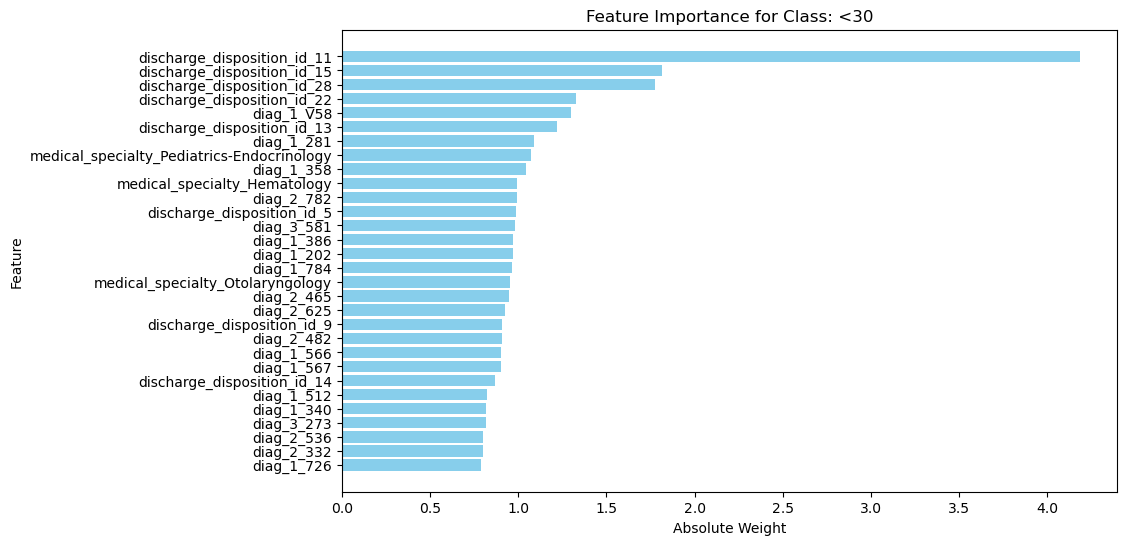

In [9]:
# Absolute weights for Class 0
class_label = "<30"  # Add the class name
abs_weights = abs(weights[0])  # For Class 0
sorted_idx = abs_weights.argsort()[-30:]  # Select the top n features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], abs_weights[sorted_idx], color='skyblue')
plt.xlabel("Absolute Weight")
plt.ylabel("Feature")
plt.title(f"Feature Importance for Class: {class_label}")
# plt.gca().invert_yaxis()  # Invert y-axis to show largest weight on bottom
plt.show()


##### **Interpreting Feature Weights**

- Across all classes:  
  - The overall features with the largest (absolute value) weights across all response classes are `discharge_disposition_id`, `diag_1`, `diag_2`, `medical_specialty`, and to a lesser extent `diag_3`, and `admission_source_id`. The largest weight for all classes was `discharge_disposition_id_11`, a category that indicates the patient 'expired'. This makes sense because patients who died are less likely to be readmitted. 

- Class 0: Early Readmitted
  - Top positive features:
    - Patients discharged to facilities such as Medicare-approved beds, psychiatric hospitals, and rehab centers were more likely to be readmitted early. Examples include:
      - `discharge_disposition_id_15`: Transferred within institution to Medicare-approved bed.
      - `discharge_disposition_id_28`: Discharged/transferred/referred to a psychiatric hospital.
      - `discharge_disposition_id_22`: Transferred to a rehab facility.
    - Specific diagnoses like `diag_1_V58`, which relates to aftercare (e.g. chemotherapy), also increase the likelihood of early readmission.
  - Top Negative Features:
    - Patients who expired (`discharge_disposition_id_11`) or were under hospice care (`discharge_disposition_id_13`) were less likely to be readmitted early, as they were no longer alive to require follow-up care.

- Class 1: Late Readmitted
  - Top Negative Features:
    - Patients who expired or were under hospice care had the strongest negative weights. These include:
      - `discharge_disposition_id_11`: Expired.
      - `discharge_disposition_id_14`: Hospice at a medical facility.
      - `discharge_disposition_id_13`: Hospice at home.
  - Top positive features:
  - Some conditions, such as `diag_1_282` (lipid metabolism disorders) and `diag_1_924` (pain-related conditions), were associated with higher odds of late readmission. This may indicate that patients with chronic conditions tend to being readmitted later.

- Class 2: Not Readmitted
  - Top positive features:
    - Patients who expired (`discharge_disposition_id_11`) or were under hospice care (`discharge_disposition_id_14` and `discharge_disposition_id_13`) were most strongly associated with not being readmitted.
  - Top Negative Features:
    - Patients receiving aftercare (e.g. chemotherapy, `diag_1_V58`) or lipid metabolism disorders (`diag_2_282`) were less likely to avoid readmission. This suggests that these individuals may have unresolved medical needs.


#### Logistic Regression with LBFGS Solver on a Subset of the Data

We also tried this with `solver='saga'`. The execution time was high (~25 min). and it didn't achieve better accuracy (0.488)

In [10]:
%%time
# Select the best dataset based on performance
X_best = X_rf_selected  # RF-derived dataset has fewer features and comparable performance
y_best = y

# Split into train/test (80/20) from the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, stratify=y_best, random_state=1234)

# Subsample the training dataset (10,000 records from X_train)
subset_size = 10000
X_train_sub, y_train_sub = resample(
    X_train, y_train, 
    replace=False,  # No replacement to avoid duplicate samples
    n_samples=subset_size, 
    random_state=1234
)

# Check sizes
print(f"Original Training Size: {X_train.shape[0]} samples")
print(f"Subsampled Training Size: {X_train_sub.shape[0]} samples")

# Initialize logistic regression with lbfgs solver
lr_clf = LogisticRegression(
    penalty='l2',
    C=1.0, 
    solver='lbfgs', 
    max_iter=5000,
    class_weight='balanced',
    n_jobs=-1, 
    random_state=1234
)

# Train on the subsampled training set
lr_clf.fit(X_train_sub, y_train_sub)

# Evaluate on the original test set
y_test_pred = lr_clf.predict(X_test)

# Calculate metrics
test_acc = mt.accuracy_score(y_test, y_test_pred)
conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

# Output results
print(f"Model Converged in {lr_clf.n_iter_} Iterations")
print(f"LBFGS Logistic Regression Test Accuracy (Full Test Set): {test_acc:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))


Original Training Size: 81412 samples
Subsampled Training Size: 10000 samples
Model Converged in [205] Iterations
LBFGS Logistic Regression Test Accuracy (Full Test Set): 0.473
Confusion Matrix:
[[ 845  787  640]
 [1898 2885 2326]
 [2095 2977 5901]]
              precision    recall  f1-score   support

         <30       0.17      0.37      0.24      2272
         >30       0.43      0.41      0.42      7109
          NO       0.67      0.54      0.59     10973

    accuracy                           0.47     20354
   macro avg       0.42      0.44      0.42     20354
weighted avg       0.53      0.47      0.49     20354

CPU times: user 432 ms, sys: 244 ms, total: 676 ms
Wall time: 7.77 s


#### Parameter Tuning for Logistic Regression with LBGFS

In [11]:
%%time
# Define parameter grid
param_grid_lbfgs = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 5000],
    'class_weight': ['balanced']
}

# Grid search for logistic regression with lbfgs solver
print("\nTuning Logistic Regression with LBFGS")
lr_clf = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    random_state=1234
)

grid_search_lbfgs = GridSearchCV(
    lr_clf, param_grid_lbfgs, cv=3, scoring='accuracy', verbose=2, n_jobs=-1
)

grid_search_lbfgs.fit(X_train_sub, y_train_sub)

# Output best parameters and CV score
print(f"Best parameters for LBFGS solver: {grid_search_lbfgs.best_params_}")
print(f"Best CV accuracy: {grid_search_lbfgs.best_score_:.3f}")



Tuning Logistic Regression with LBFGS
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..........C=1, class_weight=balanced, max_iter=5000; total time=   6.7s
[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=  16.1s
Best parameters for LBFGS solver: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
Best CV accuracy: 0.489
CPU times: user 16.4 s, sys: 232 ms, total: 16.6 s
Wall time: 27.6 s


##### **Parameter Tuning**

The C parameter controls the trade-off between achieving a low error margin and maintaining a simple decision boundary. A high C results in lower bias but higher variance, which may risk overfitting. A low C achieves higher bias and lower variance, risking underfitting. The default C is 1.0, but our model performed best with `C=0.1`. 

#### Train and Evaluate Logistic Regression with LBFGS with Tuned Parameters

We attempted this model for comparison, but it was too computationally expensive.

To run, change the execute flag to True.

In [12]:
%%time
execute = True # Change to True to run this cell
if execute:
    # Retrieve the best parameters
    best_params = grid_search_lbfgs.best_params_
    best_C_lbfgs = best_params['C']
    best_max_iter_lbfgs = best_params['max_iter']
    best_class_weight_lbfgs = best_params['class_weight']

    # Train and evaluate logistic regression with lbfgs on the full dataset
    best_lbfgs_clf = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        C=best_C_lbfgs,
        max_iter=best_max_iter_lbfgs,
        class_weight=best_class_weight_lbfgs,
        n_jobs=-1,
        random_state=1234
    )

    best_lbfgs_clf.fit(X_train, y_train)
    y_test_pred_full = best_lbfgs_clf.predict(X_test)

    # Calculate metrics
    test_acc_full = mt.accuracy_score(y_test, y_test_pred_full)
    conf_matrix_full = mt.confusion_matrix(y_test, y_test_pred_full)

    # Output results
    print(f"LBFGS Logistic Regression Test Accuracy (Full Dataset): {test_acc_full:.3f}")
    print(f"Confusion Matrix (Full Dataset):\n{conf_matrix_full}")
    print(classification_report(y_test, y_test_pred_full, target_names=['<30', '>30', 'NO']))


LBFGS Logistic Regression Test Accuracy (Full Dataset): 0.501
Confusion Matrix (Full Dataset):
[[ 961  708  603]
 [1960 2867 2282]
 [1961 2643 6369]]
              precision    recall  f1-score   support

         <30       0.20      0.42      0.27      2272
         >30       0.46      0.40      0.43      7109
          NO       0.69      0.58      0.63     10973

    accuracy                           0.50     20354
   macro avg       0.45      0.47      0.44     20354
weighted avg       0.55      0.50      0.52     20354

CPU times: user 755 ms, sys: 874 ms, total: 1.63 s
Wall time: 47.3 s


#### SGD Linear Support Vector Machine with Different Feature Subsets

In [13]:
%%time
# Define all datasets
datasets = {
    "Full Dataset": X_encoded,
    "RF Selected Features": X_rf_selected,
    "PCA (90% Variance)": X_pca_90
}

# Iterate through each dataset
for name, X in datasets.items():
    print(f"\n Running Model on: {name}")

    # Split into train (80%) and test (20%) - Stratified
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)

    # Initialize SGD Classifier for Logistic Regression
    sgd_clf = SGDClassifier(loss="hinge", penalty="l2", # Hinge loss for SVM
                            max_iter=1000, class_weight="balanced",
                            n_jobs=-1, random_state=1234)

    # Ensure X_train, X_test, y_train, y_test are NumPy arrays
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

    
    # Perform K-Fold Cross-Validation
    num_folds = 5
    cv_object = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1234)

    cv_accuracies = []
    
    for train_idx, val_idx in cv_object.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Train on training fold
        sgd_clf.fit(X_train_fold, y_train_fold)

        # Validate on validation fold
        y_val_pred = sgd_clf.predict(X_val_fold)
        acc = mt.accuracy_score(y_val_fold, y_val_pred)
        cv_accuracies.append(acc)

    print(f"Cross-Validation Mean Accuracy: {np.mean(cv_accuracies):.3f}")

    # Train Final Model on Full Training Data
    sgd_clf.fit(X_train, y_train)

    # Evaluate on Independent Test Set
    y_test_pred = sgd_clf.predict(X_test)
    test_acc = mt.accuracy_score(y_test, y_test_pred)
    conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

    print(f"Model Converged in {sgd_clf.n_iter_} Iterations")
    print(f"Final Model Test Accuracy: {test_acc:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))



 Running Model on: Full Dataset
Cross-Validation Mean Accuracy: 0.554
Model Converged in 66 Iterations
Final Model Test Accuracy: 0.572
Confusion Matrix:
[[ 238 1081  953]
 [ 313 3416 3380]
 [ 394 2596 7983]]
              precision    recall  f1-score   support

         <30       0.25      0.10      0.15      2272
         >30       0.48      0.48      0.48      7109
          NO       0.65      0.73      0.69     10973

    accuracy                           0.57     20354
   macro avg       0.46      0.44      0.44     20354
weighted avg       0.55      0.57      0.55     20354


 Running Model on: RF Selected Features
Cross-Validation Mean Accuracy: 0.545
Model Converged in 60 Iterations
Final Model Test Accuracy: 0.579
Confusion Matrix:
[[ 196  881 1195]
 [ 253 2539 4317]
 [ 320 1604 9049]]
              precision    recall  f1-score   support

         <30       0.25      0.09      0.13      2272
         >30       0.51      0.36      0.42      7109
          NO       0.62     

#### Parameter Tuning for SGD Linear Support Vector Machine

In [14]:
%%time
# Select the best dataset based on performance
X_best = X_rf_selected  # RF-derived dataset has fewer features and comparable performance
y_best = y

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, stratify=y_best, random_state=1234)

# Define hyperparameter grid
param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3],
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['adaptive', 'optimal'],
    'max_iter': [1000],
    'class_weight': ['balanced']
}

# Initialize SGDClassifier
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", n_jobs=-1, random_state=1234)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(sgd_clf, param_grid, cv=3, scoring="recall_macro", verbose=2)  # Prioritizing recall or scoring="recall_macro"
grid_search.fit(X_train, y_train)

# Best parameters and performance
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV Recall: {grid_search.best_score_:.3f}") # or Accuracy

# Train final model with best parameters
best_sgd_clf = grid_search.best_estimator_
best_sgd_clf.fit(X_train, y_train)

# Evaluate on test set
y_test_pred = best_sgd_clf.predict(X_test)
test_accuracy = mt.accuracy_score(y_test, y_test_pred)
test_recall = mt.recall_score(y_test, y_test_pred, average='macro')
conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

print(f"Final Model Test Accuracy: {test_accuracy:.3f}")
print(f"Final Model Test Recall: {test_recall:.3f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=  10.1s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=  10.9s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=adaptive, max_iter=1000; total time=  11.7s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  17.4s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  19.8s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.0001, learning_rate=optimal, max_iter=1000; total time=  16.7s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.001, learning_rate=adaptive, max_iter=1000; total time=  10.6s
[CV] END alpha=1e-05, class_weight=balanced, eta0=0.001, learning_rate=adaptive, max_iter=1000; total time=   8.9s
[CV] END alpha=1

#### Linear SVM with SVC on a Subsample of the Data

In [15]:
%%time
# Select the best dataset based on performance
X_best = X_rf_selected  # RF-derived dataset has fewer features and comparable performance
y_best = y

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, stratify=y_best, random_state=1234)

# Subsample the dataset (10,000 records)
subset_size = 10000
X_subset, y_subset = resample(
    X_train, y_train, 
    replace=False,  # No replacement, random sampling
    n_samples=subset_size, 
    random_state=1234
)

# Split the subset into train/test (80/20 split)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_subset, y_subset, 
    test_size=0.2, 
    stratify=y_subset, 
    random_state=1234
)

# Check sizes
print(f"Original Training Size: {X_train.shape[0]} samples")
print(f"Subsampled Training Size: {X_train_sub.shape[0]} samples")

# Initialize SVM model with linear kernel
svm_clf = SVC(kernel='linear', random_state=1234, C=1.0)

# Train on the subset
svm_clf.fit(X_train_sub, y_train_sub)

# Evaluate on the original test set
y_test_pred = svm_clf.predict(X_test)

# Calculate metrics
test_acc = mt.accuracy_score(y_test, y_test_pred)
conf_matrix = mt.confusion_matrix(y_test, y_test_pred)

# Output results
print(f"Linear SVM Test Accuracy (Subset): {test_acc:.3f}")
print(f"Confusion Matrix (Subset):\n{conf_matrix}")
print(mt.classification_report(y_test, y_test_pred, target_names=['<30', '>30', 'NO']))


Original Training Size: 81412 samples
Subsampled Training Size: 8000 samples
Linear SVM Test Accuracy (Subset): 0.560
Confusion Matrix (Subset):
[[  88  907 1277]
 [ 134 2745 4230]
 [ 150 2261 8562]]
              precision    recall  f1-score   support

         <30       0.24      0.04      0.07      2272
         >30       0.46      0.39      0.42      7109
          NO       0.61      0.78      0.68     10973

    accuracy                           0.56     20354
   macro avg       0.44      0.40      0.39     20354
weighted avg       0.52      0.56      0.52     20354

CPU times: user 1min 10s, sys: 354 ms, total: 1min 10s
Wall time: 1min 10s


#### Parameter Tuning for Linear SVM with SVC

In [16]:
# Define parameter grids
param_grid_linear = {
    'C': [0.1, 1, 10, 100]
}

# Linear SVM Grid Search
print("\nTuning Linear Kernel SVM")
svm_linear = SVC(kernel='linear', random_state=1234)
grid_search_linear = GridSearchCV(
    svm_linear, param_grid_linear, cv=3, scoring='accuracy', verbose=2, n_jobs=-1
)
grid_search_linear.fit(X_train_sub, y_train_sub)

# Assign the best parameter for C
best_C_linear = grid_search_linear.best_params_['C']
print(f"Best parameters for linear kernel: {grid_search_linear.best_params_}")
print(f"Best CV accuracy: {grid_search_linear.best_score_:.3f}")

# Evaluate Best Model on the Original Test Set
best_linear_svm = grid_search_linear.best_estimator_
y_test_pred_linear = best_linear_svm.predict(X_test)
linear_test_acc = mt.accuracy_score(y_test, y_test_pred_linear)
print(f"Linear SVM Test Accuracy (Best Params): {linear_test_acc:.3f}")
print(mt.classification_report(y_test, y_test_pred_linear, target_names=['<30', '>30', 'NO']))



Tuning Linear Kernel SVM
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for linear kernel: {'C': 0.1}
Best CV accuracy: 0.573
Linear SVM Test Accuracy (Best Params): 0.578
              precision    recall  f1-score   support

         <30       0.36      0.01      0.01      2272
         >30       0.51      0.29      0.37      7109
          NO       0.60      0.89      0.71     10973

    accuracy                           0.58     20354
   macro avg       0.49      0.39      0.36     20354
weighted avg       0.54      0.58      0.51     20354



#### Train and Evaluate Linear SVM (with SVC) with Tuned Parameters

We attempted this model for comparison, but it was too computationally expensive. 

To run, change the `execute` flag to `True`.

We also tried `SVC` with `kernel='rbf'` tuning both C and gamma, but we didn't improve accuracy or recall (0.584 and 0.03 for the early readmitted class).

In [17]:
%%time
execute = False  # Change to True to run this cell
if execute:
    # Train and evaluate linear SVM on the full dataset
    best_linear_svm = SVC(kernel='linear', C=best_C_linear, random_state=1234)
    best_linear_svm.fit(X_train, y_train)
    y_test_pred_full_linear = best_linear_svm.predict(X_test)
    test_acc_full_linear = mt.accuracy_score(y_test, y_test_pred_full_linear)
    conf_matrix_full_linear = mt.confusion_matrix(y_test, y_test_pred_full_linear)
    print(f"Linear SVM Test Accuracy (Full Dataset): {test_acc_full_linear:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix_full_linear}")
    print(mt.classification_report(y_test, y_test_pred_full_linear, target_names=['<30', '>30', 'NO']))


CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.15 μs


#### Examine the Support Vectors from Tuned Linear SVM (with SVC) on a Subsample of the Data

Top 10 Influential Features for Class 0:
                          Feature  Weight
2200  discharge_disposition_id_22     1.2
2003                   diag_1_785     0.3
2040                   diag_1_824     0.3
1556                   diag_1_202     0.3
892                    diag_3_332     0.2
89                     diag_2_255     0.2
1551                   diag_1_197     0.2
1619                   diag_1_288     0.2
858                    diag_3_288    -0.2
1584                   diag_1_238     0.2


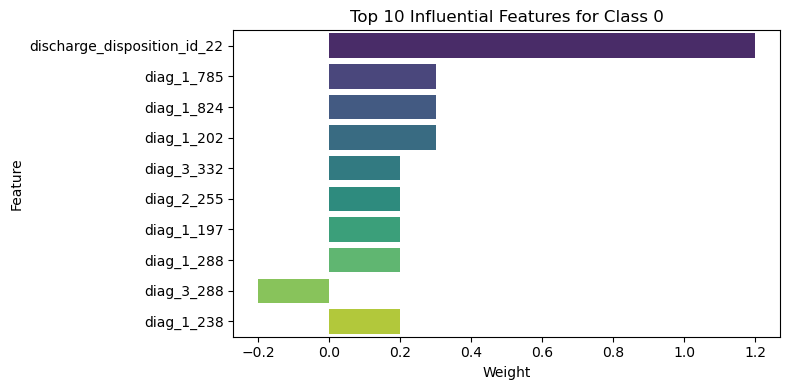

Linear SVM Test Accuracy (Subsampled Dataset): 0.578
Confusion Matrix:
[[  16  729 1527]
 [  20 2030 5059]
 [   8 1244 9721]]
              precision    recall  f1-score   support

         <30       0.36      0.01      0.01      2272
         >30       0.51      0.29      0.37      7109
          NO       0.60      0.89      0.71     10973

    accuracy                           0.58     20354
   macro avg       0.49      0.39      0.36     20354
weighted avg       0.54      0.58      0.51     20354

Number of support vectors (Linear): 6524


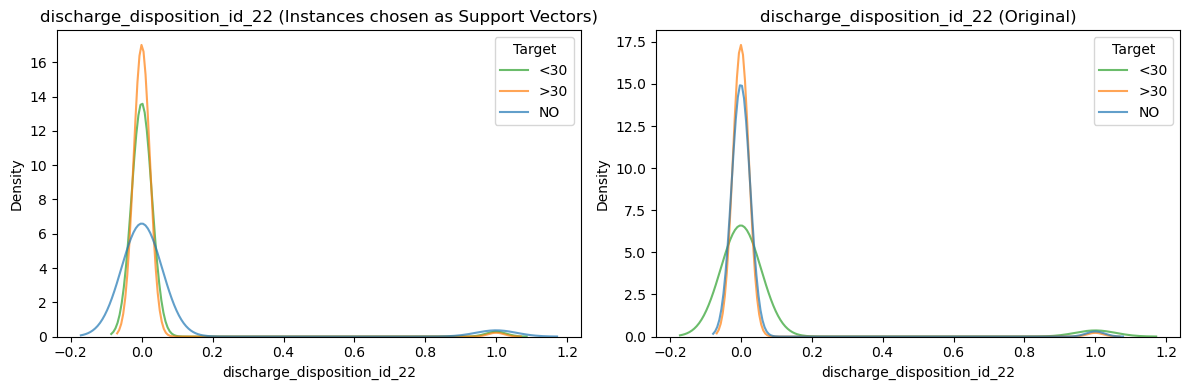

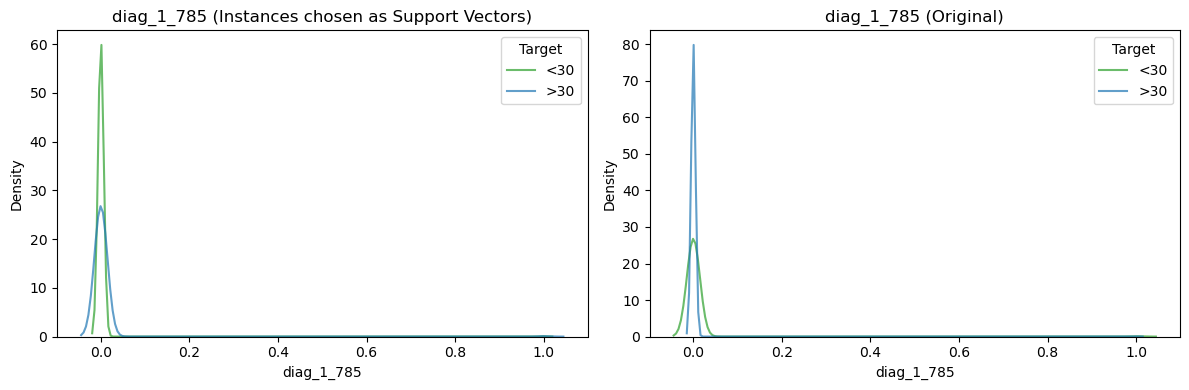

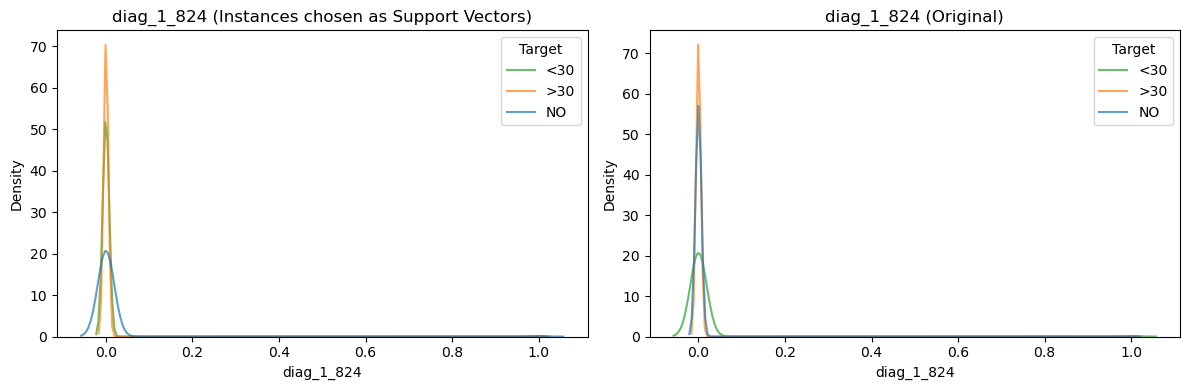

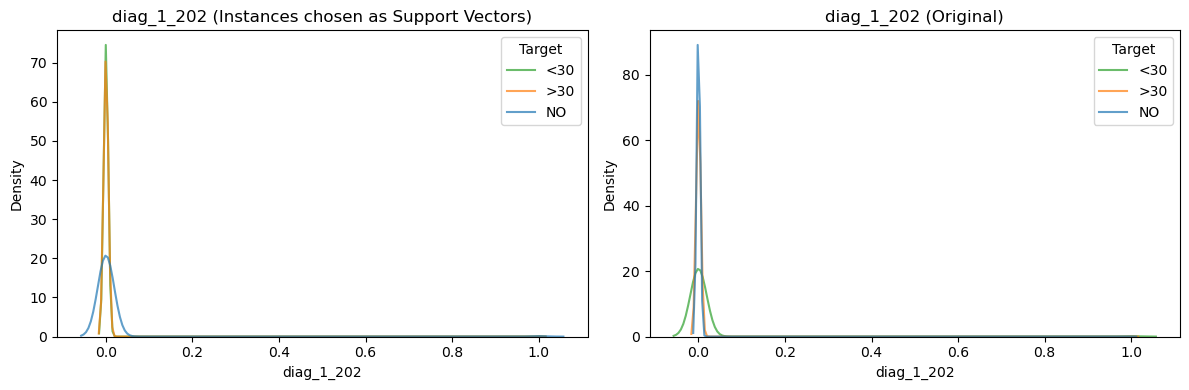

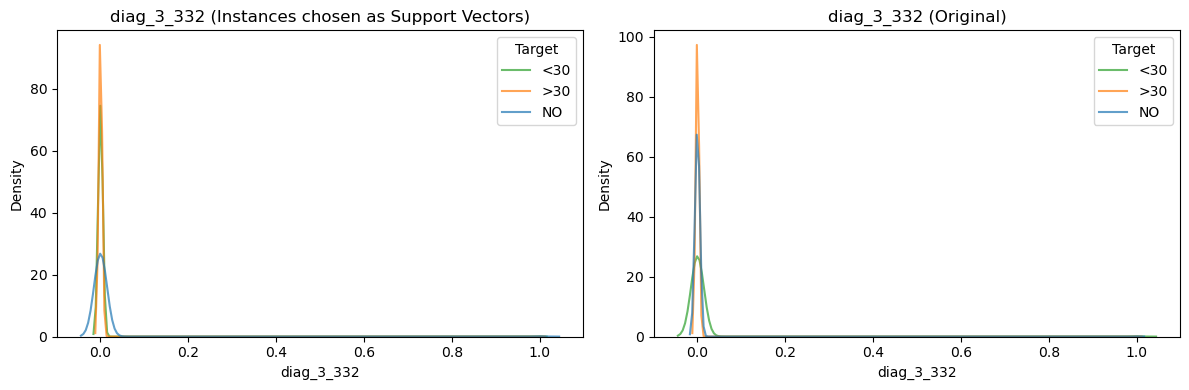

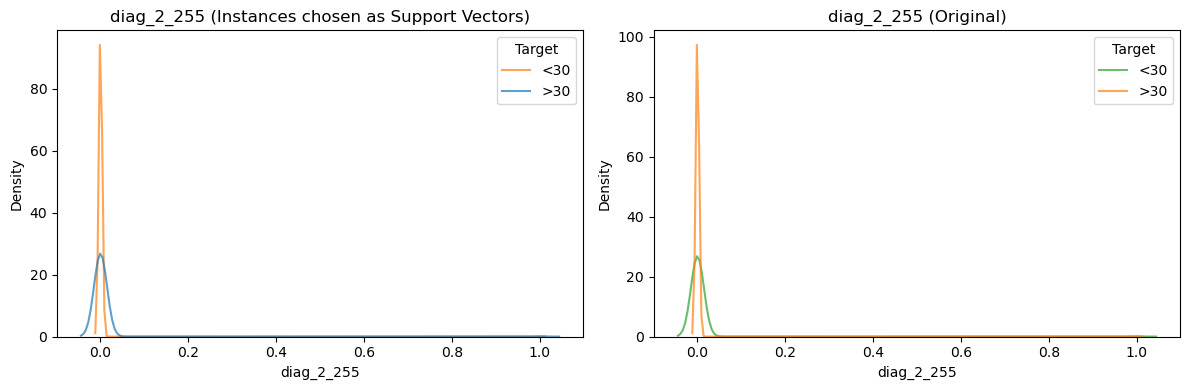

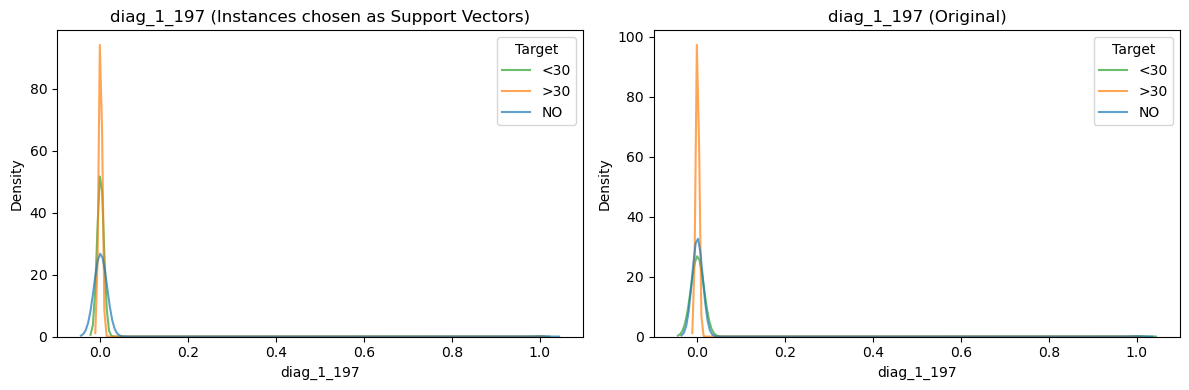

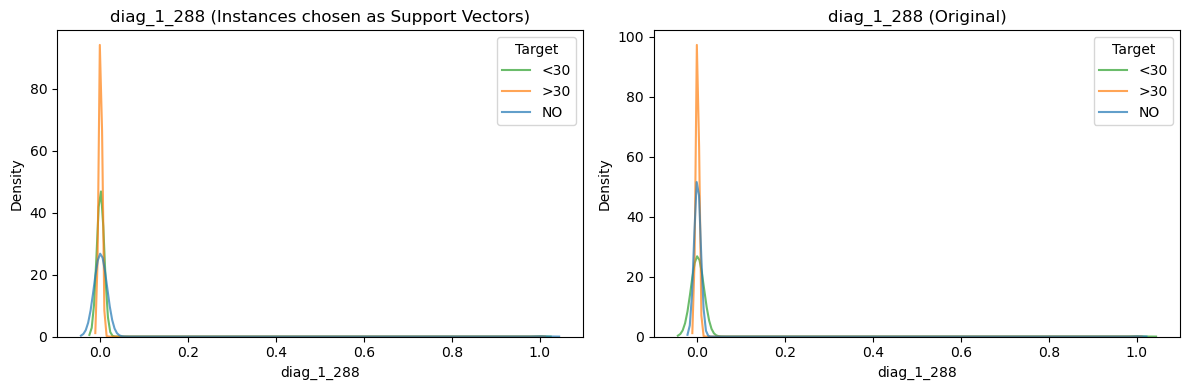

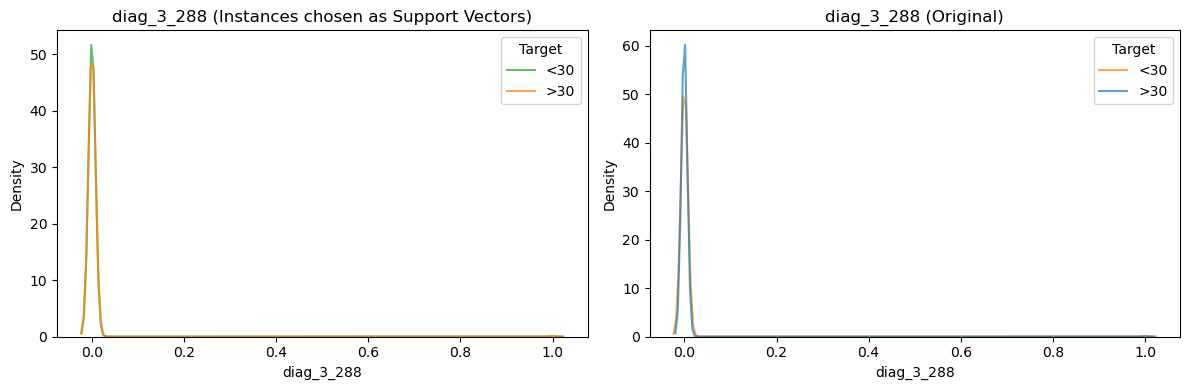

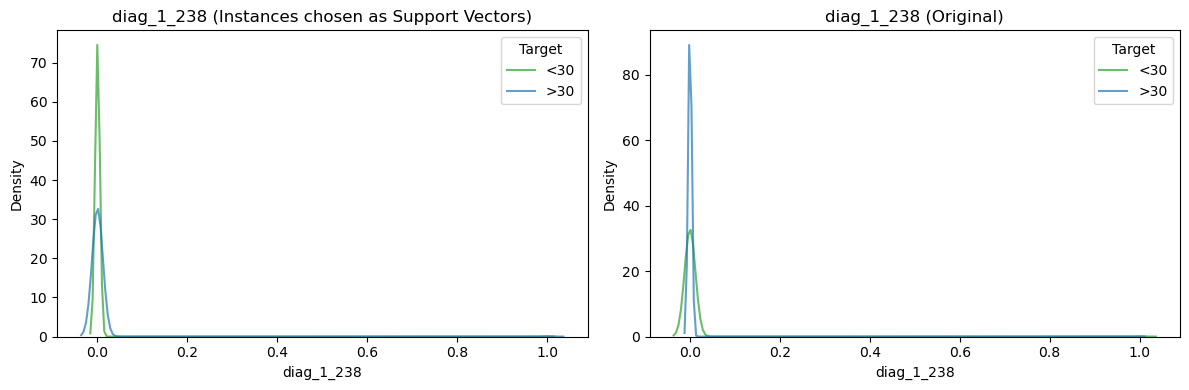

In [18]:
# Get the coefficients from the trained linear SVM model (or SGD hinge (SVM) model)
weights = best_linear_svm.coef_[0]  # Coefficients for class 0

# Create a DataFrame for feature names and weights
feature_weights = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': weights
})

# Sort by the absolute value of weights to identify influential features
top_features = feature_weights.reindex(feature_weights['Weight'].abs().sort_values(ascending=False).index)

# Select the top N influential features (e.g. top 10)
N = 10
top_features = top_features.head(N)

print(f"Top {N} Influential Features for Class 0:")
print(top_features)

# Plotting top features with their weights
plt.figure(figsize=(8, 4))
sns.barplot(data=top_features, x='Weight', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title(f"Top {N} Influential Features for Class 0")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Train and evaluate linear SVM on the subsampled dataset
linear_svm = SVC(kernel='linear', C=best_C_linear, random_state=1234)
linear_svm.fit(X_train_sub, y_train_sub)
y_test_pred_linear = linear_svm.predict(X_test)
test_acc_linear = mt.accuracy_score(y_test, y_test_pred_linear)
conf_matrix_linear = mt.confusion_matrix(y_test, y_test_pred_linear)
print(f"Linear SVM Test Accuracy (Subsampled Dataset): {test_acc_linear:.3f}")
print(f"Confusion Matrix:\n{conf_matrix_linear}")
print(mt.classification_report(y_test, y_test_pred_linear, target_names=['<30', '>30', 'NO']))

# Extract support vector indices
support_indices_linear = linear_svm.support_
print(f"Number of support vectors (Linear): {len(support_indices_linear)}")

# Create a DataFrame for the subsampled training data
X_train_sub_df = pd.DataFrame(X_train_sub, columns=X_train.columns)
y_train_sub_df = pd.Series(y_train_sub, name="Target")

# Extract support vector data
df_support_linear = X_train_sub_df.iloc[support_indices_linear].copy()
df_support_linear["Target"] = y_train_sub_df.iloc[support_indices_linear].astype(str)  # Ensure categorical hue

# Ensure Target is categorical
df_support_linear["Target"] = df_support_linear["Target"].astype(str)
y_train_sub_df = y_train_sub_df.astype(str)

# Use the top influential features for plotting
features_to_plot = top_features['Feature'].tolist()

# KDE plotting for the top features
for feature in features_to_plot:
    if X_train_sub_df[feature].var() > 0:  # Skip features with zero variance
        plt.figure(figsize=(12, 4))
        
        # Plot KDE for support vectors
        plt.subplot(1, 2, 1)
        sns.kdeplot(
            data=df_support_linear, 
            x=feature, 
            hue="Target", 
            fill=False,  # Disable fill for outline plots
            common_norm=False, 
            alpha=0.7,
            warn_singular=False
        )
        plt.title(f"{feature} (Instances chosen as Support Vectors)")
        plt.legend(title="Target", labels=['<30', '>30', 'NO'])
        
        # Plot KDE for all data
        plt.subplot(1, 2, 2)
        sns.kdeplot(
            data=X_train_sub_df, 
            x=feature, 
            hue=y_train_sub_df, 
            fill=False,  # Disable fill for outline plots
            common_norm=False, 
            alpha=0.7,
            warn_singular=False
        )
        plt.title(f"{feature} (Original)")
        plt.legend(title="Target", labels=['<30', '>30', 'NO'])
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature '{feature}' has 0 variance; skipping plot.")


##### **Interpretation of Support Vectors**

Here, we chose to plot the support vectors for the top weighted variables in the early admitted class. If we had plotted more of the features, we may have seen more peaks around 1, potentially indicating these features as stronger separators for the readmitted class. Most of the KDE plots showed that most selected cases didn't have much separation between the readmitted classes. This means these features might not contribute much useful information the the SVM model. Going forward we can potentially implement stronger decision boundaries and drop features to simplify the model.

##### **Model Comparison**

The advantage of the logistic regression model is interpretability. We can see which features are most associated with each response class. It is best used for linearly separable data, and it is useful when you need to estimate class probabilities.

In our case, with both a linear and a radial basis function and tuned parameters, the accuracy between the SVM and logistic regression models were similar. Though generally SVM models have more flexibility in the decision boundaries, can work well with complex datasets, and can achieve higher accuracy if tuned properly. On the downside, they take much more compute power and execution time compared to logistic regression and SGD models.